# Богданов Александр Иванович, Б05-003

## Генерация аннотации к изображению

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.models as models

from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Вспомогательные функции

In [3]:
class Tokenizer(object):
    def __init__(self, word_to_ind, tokenizer):
        self.word_to_ind = word_to_ind
        self.tokenizer = tokenizer
    def __call__(self, sentences, max_length = 10, pad_to_max_length = False):
        tokens = self.tokenizer.tokenize_sents(sentences)
        if not pad_to_max_length:
            max_length = min(max_length, max(map(len, tokens)))
        tokens = [['[CLS]'] + s + ['[SEP]'] + ['[PAD]']*(max_length-len(s)) \
                  if len(s) < max_length \
                  else ['[CLS]'] + s[:max_length] + ['[SEP]'] \
                  for s in tokens ]
        ids = [[self.word_to_ind.get(w, self.word_to_ind['[UNK]']) for w in sent] for sent in tokens]
        return torch.tensor(ids)

In [4]:
def word_dict(dataset_train, trashhold=1):
    helps = {}
    for sent in tqdm(dataset_train):
        for word in RegexpTokenizer('[a-zA-Z]+|[^\w\s]|\d+').tokenize(sent):
            if word in helps:
                helps[word] += 1
            else:
                helps[word] = 1
    
    word2idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3}
    idx2word = {0: '[PAD]', 1: '[UNK]', 2: '[CLS]', 3: '[SEP]'}
    for elem, number in helps.items():
        if number >= trashhold and elem not in word2idx:
            word2idx[elem] = len(word2idx)
            idx2word[len(idx2word)] = elem
    
    return word2idx, idx2word

In [5]:
class CastomDataset(Dataset):
    def __init__(self, images, captions, transform):
        self.images = images
        self.captions = captions
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.transform(Image.open(self.images[index]).convert('RGB')), self.captions[index]

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
back_transform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

In [8]:
def check(batch_size, dataset, model, loss_function, idx2word, index=0):
    
    model.eval()
            
    batch_generator = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size)
            
    x_batch, y_batch = next(iter(batch_generator))
    x_batch = x_batch.to(model.device)
    y_batch = y_batch.to(model.device)
        
    output = model(x_batch)

    test_loss = loss_function(output.transpose(1,2), y_batch).cpu().item()*len(x_batch) / len(dataset)  

    print(f'loss on batch: {test_loss}')
    
    
    x = torch.stack([dataset_test[index][0], dataset_test[index + 1][0], dataset_test[index + 2][0]])
            
    preds = torch.argmax(model(x.to(model.device)), dim=-1).cpu()
    f, ax = plt.subplots(1, 3, figsize=(8, 6))
    annotation = ''
    
    ans = ''
    for pred in preds[0]:
        ans += idx2word[pred.item()] + ' '
    ax[0].imshow(back_transform(x[0].cpu()).permute(1,2,0))
    ax[0].set_title('Картинка 1')
    
    annotation += 'Картинка 1 Аннотация: ' + ans + '\n'
    
    ans = ''
    for pred in preds[1]:
        ans += idx2word[pred.item()] + ' '
    ax[1].imshow(back_transform(x[1].cpu()).permute(1,2,0))
    ax[1].set_title('Картинка 2')
    
    annotation += 'Картинка 2 Аннотация: ' + ans + '\n'
    
    ans = ''
    for pred in preds[2]:
        ans += idx2word[pred.item()] + ' '
    ax[2].imshow(back_transform(x[2].cpu()).permute(1,2,0))
    ax[2].set_title('Картинка 3')
    
    annotation += 'Картинка 3 Аннотация: ' + ans + '\n'
    
    plt.show()
    print(annotation)
    
    return test_loss

In [9]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 300, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.dataset = dataset

    def forward(self, model, loss):
        model.eval()
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            model.eval()
            
            batch_generator = torch.utils.data.DataLoader(dataset=self.dataset, batch_size=self.batch_size)
            
            x_batch, y_batch = next(iter(batch_generator))
            x_batch = x_batch.to(model.device)
            y_batch = y_batch.to(model.device)
                
            output = model(x_batch)
            
            test_loss = self.loss_function(output.transpose(1,2), y_batch).cpu().item()*len(x_batch) / len(self.dataset)

            print(f"\t\tstep={self.step}, train_loss={loss}, val_loss={test_loss}")
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [10]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(model.device))
    
    loss = loss_function(output.transpose(1,2), y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [11]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [12]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

## Модель

In [13]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.linear = torch.nn.Linear(resnet.fc.in_features, latent_dim)
        
    def forward(self, images):
        with torch.no_grad():
            out = self.resnet(images)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_dim, latent_dim, emb_dim, hidden_dim, num_layers=3, dropout=0, batch_norm=False):
        super(type(self), self).__init__()
        
        self.num_layers = num_layers
        
        self.h0 = torch.nn.Linear(latent_dim, hidden_dim)
        self.c0 = torch.nn.Linear(latent_dim, hidden_dim)
        
        self.emb = torch.nn.Embedding(1, emb_dim)
        
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        if batch_norm:
            self.batch_norm = nn.BatchNorm1d(emb_dim)
        else:
            self.batch_norm = None
        self.linear = torch.nn.Linear(hidden_dim, vocab_dim)

    def forward(self, latent_vector):
        
        h = self.h0(latent_vector).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = self.c0(latent_vector).unsqueeze(0).repeat(self.num_layers, 1, 1)
        
        emb = self.emb(torch.zeros(len(latent_vector), 1).long())

        logits = []
        for i in range(12):
            out, (h, c) = self.lstm(emb, (h, c))
                
            if self.batch_norm is not None:
                out = self.batch_norm(out.transpose(1,2)).transpose(1,2)
                
            logits.append(out[:,-1,:])
        
        out = torch.stack(logits, 1)
        out = self.linear(out)
        return out

In [15]:
class Autoencoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_dim, latent_dim = 128, emb_dim=128, hidden_dim=128, num_layers=3):
        super(type(self), self).__init__()
        
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(vocab_dim, latent_dim, emb_dim, hidden_dim, num_layers)
    
    def forward(self, images):
        return self.decoder(self.encoder(images))

## Подключим tensorboard

In [30]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_5/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 41105), started 1 day, 16:56:18 ago. (Use '!kill 41105' to kill it.)

## Скачаем данные

In [31]:
with open('captions.json', 'r') as f:
    data = json.load(f)

In [32]:
pic2cap = {}
for elem in data['annotations']:
    pic2cap[elem['image_id']] = elem['caption']

In [33]:
images_paths, captions = [], []
for path in os.listdir('Pictures'):
    images_paths.append('Pictures/' + path)
    captions.append(pic2cap[int(path[13:-4])])

In [34]:
word2idx, idx2word = word_dict(captions)

  0%|          | 0/40504 [00:00<?, ?it/s]

In [35]:
train_images, test_images, train_captions, test_captions = train_test_split(images_paths, captions, train_size=0.9)

In [36]:
tokenizer = Tokenizer(word2idx, RegexpTokenizer('[a-zA-Z]+|[^\w\s]|\d+'))

In [37]:
dataset_train = CastomDataset(train_images, tokenizer(train_captions), transform)
dataset_test = CastomDataset(test_images, tokenizer(test_captions), transform)

## Обучение

In [38]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [39]:
model = Autoencoder(vocab_dim=len(word2idx))
model.to(device)

writer = SummaryWriter(log_dir = f'tensorboard_5/experiment')
call = callback(writer, dataset_test, loss_function, delimeter = 100)

loss on batch: 0.0628449895063526


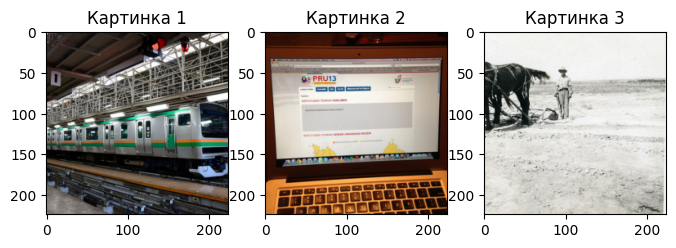

Картинка 1 Аннотация: [CLS] A train train a a a a a . [SEP] [SEP] 
Картинка 2 Аннотация: [CLS] A computer of a a a a a a [SEP] [SEP] 
Картинка 3 Аннотация: [CLS] A group of a a a a a a [SEP] [SEP] 



epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

		step=1300, train_loss=3.985248327255249, val_loss=0.0629603212422955
		step=1400, train_loss=3.8264412879943848, val_loss=0.06279229376234263
		step=1500, train_loss=3.868583917617798, val_loss=0.06255905012000317
		step=1600, train_loss=4.0002923011779785, val_loss=0.0622454030929863
		step=1700, train_loss=3.8480677604675293, val_loss=0.061705461933829996
		step=1800, train_loss=3.998283863067627, val_loss=0.06160677135564521
loss on batch: 0.061309464152610856


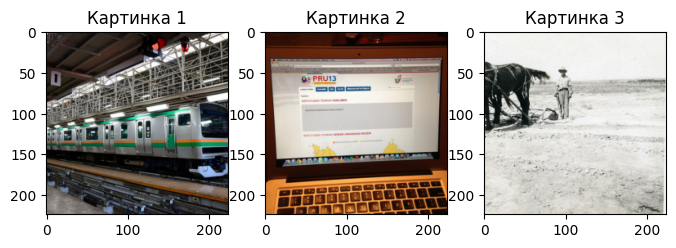

Картинка 1 Аннотация: [CLS] A train train train train train a train train [SEP] [SEP] 
Картинка 2 Аннотация: [CLS] A computer of a a a a a a . [SEP] 
Картинка 3 Аннотация: [CLS] A horse of a a a a a a [SEP] [SEP] 



0.061309464152610856

In [43]:
check(64, dataset_test, model, loss_function, idx2word, index=101)
trainer(count_of_epoch=1, 
        batch_size=64, 
        dataset=dataset_train,
        model=model,
        loss_function=loss_function,
        optimizer = optimizer,
        lr=1e-3,
        callback=call)
check(64, dataset_test, model, loss_function, idx2word, index=101)

Как мы видим, модель научилась определять что-то на картинках.